# Prediction Model #1 - ARIMA Model

## 1. Setup and Data Loading

### 1.1 Load Libraries

Import the appropriate libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_absolute_percentage_error as mape, root_mean_squared_error as rmse, mean_squared_error as mse, mean_absolute_error as mae, r2_score as r2

### 1.2 Load Datasets

In [3]:
df = pd.read_csv('../final dataset/Ventolin_df.csv', index_col= 'Unnamed: 0')
df24 = pd.read_csv('../final dataset/Ventolin2024_df.csv', index_col= 'Unnamed: 0')

## 2. Data Preprocessing

### 2.1 Parse and Format Dates

Create an index that is date time

In [4]:
# Define a function to handle both 'yyyymmdd' and 'yyyymm' formats
def parse_date(date_str):
    # Remove any decimal places (e.g., "201609.0" becomes "201609")
    date_str = str(date_str).split('.')[0]
    
    if len(date_str) == 6:  # yyyymm format
        return pd.to_datetime(date_str, format='%Y%m')  # Convert yyyymm
    elif len(date_str) == 8:  # yyyymmdd format
        return pd.to_datetime(date_str, format='%Y%m%d')  # Convert yyyymmdd
    else:
        return pd.NaT  # If the format is unexpected, return NaT

# Apply the function to 'rept_dt' column
df['rept_dt'] = df['rept_dt'].apply(parse_date)

# Check for any NaT values (dates that could not be parsed)
if df['rept_dt'].isnull().any():
    print("Some dates could not be parsed")

# Set 'rept_dt' as the index (if needed)
df = df.set_index('rept_dt')

# Display the first few rows to check the conversion
# df.tail()

Some dates could not be parsed


In [5]:
# Apply the function to 'rept_dt' column
df24['rept_dt'] = df24['rept_dt'].apply(parse_date)

# Check for any NaT values (dates that could not be parsed)
if df24['rept_dt'].isnull().any():
    print("Some dates could not be parsed")

# Set 'rept_dt' as the index (if needed)
df24 = df24.set_index('rept_dt')

# Display the first few rows to check the conversion
# df.tail()

### 2.2 Aggregate Data by Month

In [ ]:
df_grouped = df.groupby(pd.Grouper(freq='M')).size()
df_grouped = df_grouped.asfreq('M').fillna(0)
df_grouped = df_grouped.loc['2013':'2023']

/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_7133/177091413.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_grouped = df.groupby(pd.Grouper(freq='M')).size()


In [9]:
df24_grouped = df24.groupby(pd.Grouper(freq='M')).size().asfreq('M').fillna(0)

/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_7133/187470941.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df24_grouped = df24.groupby(pd.Grouper(freq='M')).size().asfreq('M').fillna(0)
/var/folders/hl/ycrf0lts4_3163_3nfknhyb00000gn/T/ipykernel_7133/187470941.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df24_grouped = df24.groupby(pd.Grouper(freq='M')).size().asfreq('M').fillna(0)


Split the data

In [ ]:
#  split data into training and testing sets
train_data = df_grouped.loc[:'2020']
test_data = df_grouped.loc['2021':]

## 3. Stationarity Check

<Axes: xlabel='rept_dt'>

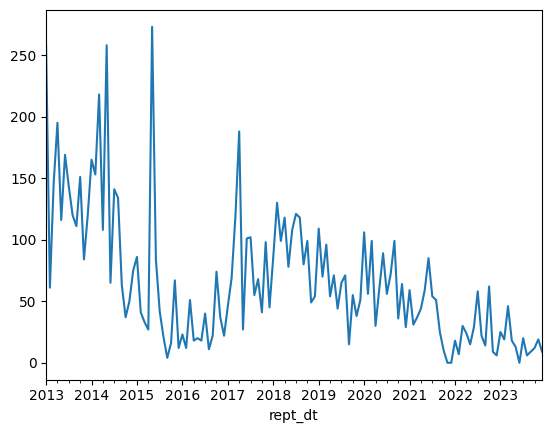

In [ ]:
# Plot and perform stationarity check
df_grouped.plot(title='Ventolin Adverse Events Over Time')

In [12]:
diff_data = df_grouped.diff().dropna()

Perform ADF Test

In [14]:

result = adfuller(df_grouped)
print('ADF Statistics:', result[0])
print('p-value:', result[1])

ADF Statistics: -2.8886158114894918
p-value: 0.04668792968719292


## 4. Model Building

### 4.1 ARIMA Model Parameters

#### Find best ARIMA configuration

In [15]:
from pmdarima import auto_arima
# arima_model = auto_arima(df_grouped, seasonal=True, m=12, stepwise=True, trace=True, suppress_warnings=True,information_criterion='aic')
arima_model = auto_arima(train_data, seasonal=True,m=12, stepwise=True, trace=True, suppress_warnings=True,information_criterion='aic')

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=1016.298, Time=0.52 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=1058.388, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=1028.398, Time=0.07 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1009.553, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=1056.529, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=1011.794, Time=0.02 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=1010.509, Time=0.08 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=1009.710, Time=0.68 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=1011.048, Time=0.07 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=1011.450, Time=0.70 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=1054.240, Time=0.04 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=1011.332, Time=0.08 sec
 ARIMA(0,1,2)(0,0,1)[12] intercept   : AIC=1011.351, Time=0.06 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=1027.763, Time=0.08 sec
 ARIMA(1,1,2)(0,0,1

In [ ]:
best_order = arima_model.order
best_seasonal_order = arima_model.seasonal_order

print(f"Best ARIMA order: {best_order}")
print(f"Best seasonal order: {best_seasonal_order}")

Best ARIMA order: (0, 1, 1)
Best seasonal order: (0, 0, 1, 12)


#### Manually Check Seasonality - Plot ACF and PACF

<Figure size 1200x600 with 0 Axes>

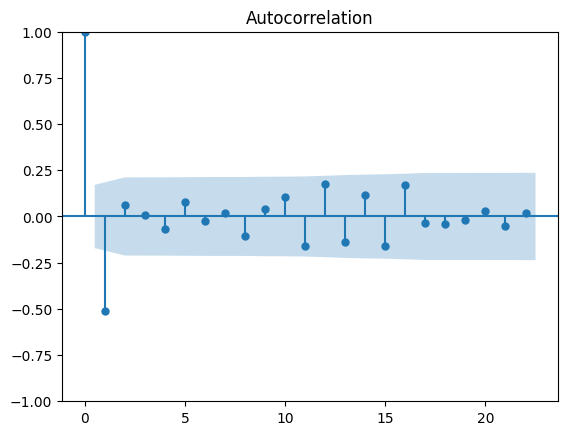

<Figure size 1200x600 with 0 Axes>

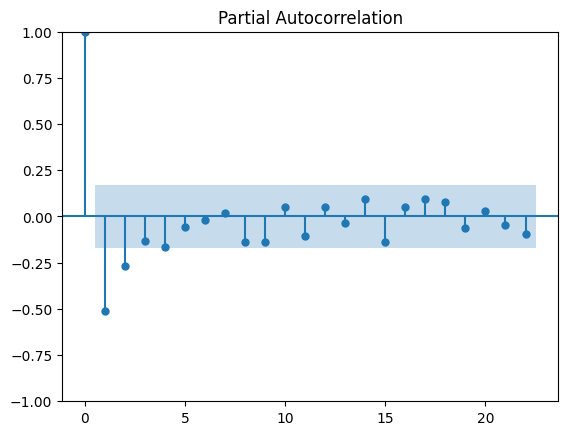

In [17]:
plt.figure(figsize=(12, 6))
plot_acf(diff_data)
plt.show()

plt.figure(figsize=(12, 6))
plot_pacf(diff_data)
plt.show()

### 4.2 Fit the Model

In [18]:
model = ARIMA(df_grouped, order=best_order, seasonal_order= best_seasonal_order)
model_fit = model.fit()

In [19]:
print(model_fit.summary())

                                    SARIMAX Results                                     
Dep. Variable:                                y   No. Observations:                  132
Model:             ARIMA(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -673.509
Date:                          Wed, 20 Nov 2024   AIC                           1353.019
Time:                                  20:47:13   BIC                           1361.644
Sample:                              01-31-2013   HQIC                          1356.523
                                   - 12-31-2023                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7803      0.048    -16.096      0.000      -0.875      -0.685
ma.S.L12       0.2801      0.078      3.611      0.

## 5. Forecasting in 2024

In [ ]:
# Forecast future values
forecast_fit = model_fit.forecast(steps = 12)
forecast = forecast_fit[:6]

### Plot Adverse Events

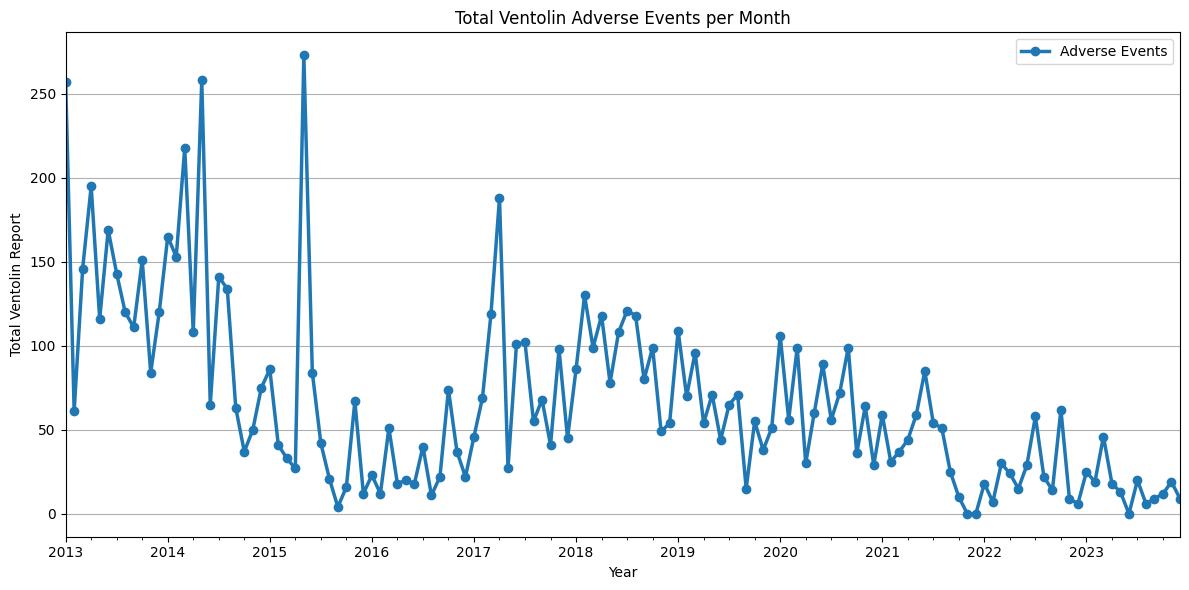

In [ ]:
# Plot Total Adverse Events
plt.figure(figsize=(12,6))
df_grouped.plot(label = 'Adverse Events', marker = 'o', linewidth = 2.5)
plt.title('Total Ventolin Adverse Events per Month')
plt.xlabel('Year')
plt.ylabel('Total Ventolin Report')
plt.grid(True, which='both', axis='y')
plt.tight_layout() 
plt.legend()
plt.show()


### Plot Forecast

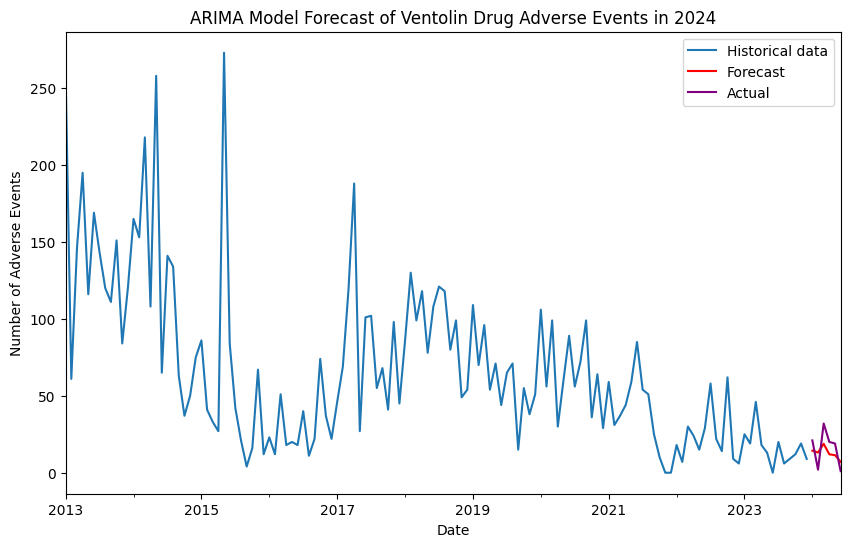

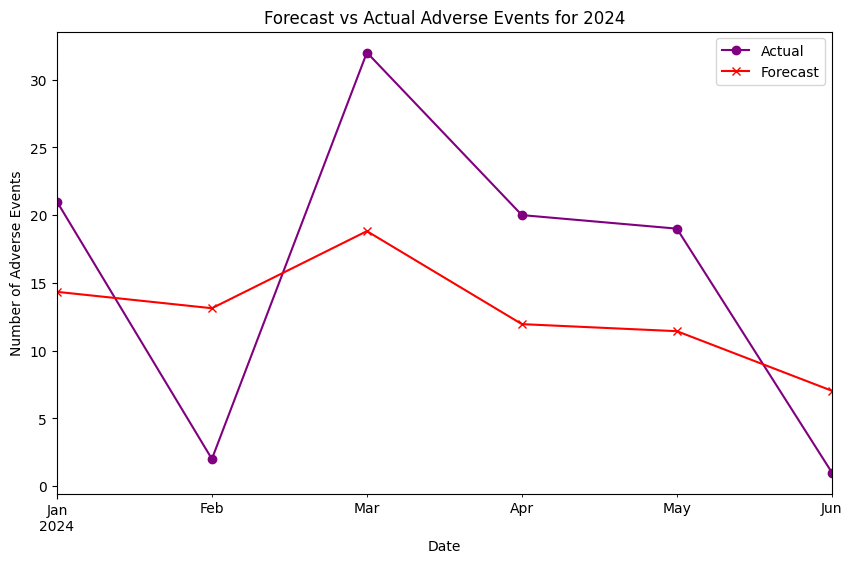

In [ ]:
plt.figure(figsize=(10,6))
df_grouped.plot(label = 'Historical data')
forecast.plot(label = 'Forecast', color = 'red')
df24_grouped.plot(label = 'Actual', color = 'purple')
plt.title('ARIMA Model Ventolin Drug Adverse Events in 2024')
plt.xlabel('Date')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
df24_grouped.plot(label='Actual', marker='o', color = 'purple')
forecast.plot(label='Forecast', marker='x', color = 'red')
plt.title('ARIMA Model Forecast Adverse Events 2024')
plt.xlabel('Date')
plt.ylabel('Number of Adverse Events')
plt.legend()
plt.show()


## 6. Evaluation of ARIMA Model Forecast

### 6.1 Align Data

In [24]:
# Align the index of actual and forecasted values
actual = df24_grouped
forecast_aligned = forecast[actual.index]

### 6.2 Calculate Metrics

In [ ]:
# Calculate evaluation metrics
mae_score = mae(actual, forecast_aligned)
rmse_score = np.sqrt(mse(actual, forecast_aligned))
mape_score = mape(actual, forecast_aligned)
r2_score = r2(actual,  forecast_aligned)
print(f"Mean Absolute Error (MAE): {mae_score}")
print(f"Root Mean Squared Error (RMSE): {rmse_score}")
print(f"Mean Absolute Percentage Error (MAPE), {mape_score}")
print(f"R-Squared (R^2), {r2_score}")

Mean Absolute Error (MAE): 8.77032798912214
Root Mean Squared Error (RMSE): 9.132731883917298
Mean Absolute Percentage Error (MAPE), 2.187818832208638
R-Squared (R^2), 0.311477986726277
